# Predator-Prey Simulation (Predictive Predator & Evasive Prey)

This notebook contains a complete predator-prey simulation in a 2D bounded world.

- **Predator**: Uses a predictive interception heuristic (aims toward predicted future prey position).
- **Prey**: Uses an evasive behavior (moves away from the predator with jitter/wander).

The notebook includes code to run the simulation, visualize trajectories, and animate the chase.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
np.random.seed(1)

xlim, ylim = (0, 10), (0, 10)

class Agent:
    def __init__(self, pos, speed=1.0):
        self.pos = np.array(pos, dtype=float)
        self.speed = float(speed)
    def distance_to(self, other):
        return np.linalg.norm(self.pos - other.pos)

class Prey(Agent):
    def __init__(self, pos, speed=1.2, max_turn=np.pi/4):
        super().__init__(pos, speed)
        self.velocity = np.random.randn(2)
        self.velocity = self.velocity / np.linalg.norm(self.velocity) * self.speed
        self.max_turn = max_turn
    def step(self, predator, dt=0.1):
        away = self.pos - predator.pos
        if np.linalg.norm(away) < 1e-6:
            away = np.random.randn(2)
        away_dir = away / np.linalg.norm(away)
        jitter = np.random.randn(2) * 0.3
        desired = away_dir + 0.5 * jitter
        if np.linalg.norm(self.velocity) < 1e-8:
            self.velocity = np.array([1.0, 0.0])
        cur_dir = self.velocity / np.linalg.norm(self.velocity)
        des_dir = desired / np.linalg.norm(desired)
        ang = np.arctan2(des_dir[1], des_dir[0]) - np.arctan2(cur_dir[1], cur_dir[0])
        ang = (ang + np.pi) % (2*np.pi) - np.pi
        ang = np.clip(ang, -self.max_turn*dt*10, self.max_turn*dt*10)
        c, s = np.cos(ang), np.sin(ang)
        R = np.array([[c, -s], [s, c]])
        new_dir = R.dot(cur_dir)
        self.velocity = new_dir / np.linalg.norm(new_dir) * self.speed
        self.pos += self.velocity * dt
        self.pos[0] = np.clip(self.pos[0], xlim[0], xlim[1])
        self.pos[1] = np.clip(self.pos[1], ylim[0], ylim[1])

class Predator(Agent):
    def __init__(self, pos, speed=1.4):
        super().__init__(pos, speed)
        self.velocity = np.zeros(2)
    def interception_target(self, prey):
        p = self.pos
        q = prey.pos
        vq = getattr(prey, 'velocity', np.zeros(2))
        rel = q - p
        rel_speed_sq = np.dot(vq, vq)
        if rel_speed_sq < 1e-6:
            return q
        dist = np.linalg.norm(rel)
        t_pred = dist / (self.speed + 1e-6)
        pred_point = q + vq * t_pred
        return pred_point
    def step(self, prey, dt=0.1):
        target = self.interception_target(prey)
        dir_to = target - self.pos
        if np.linalg.norm(dir_to) < 1e-8:
            dir_unit = np.zeros(2)
        else:
            dir_unit = dir_to / np.linalg.norm(dir_to)
        self.velocity = dir_unit * self.speed
        self.pos += self.velocity * dt
        self.pos[0] = np.clip(self.pos[0], xlim[0], xlim[1])
        self.pos[1] = np.clip(self.pos[1], ylim[0], ylim[1])


def run_simulation(dt=0.1, max_steps=800, capture_radius=0.3,
                   prey_start=(8.0,5.0), predator_start=(2.0,2.0),
                   prey_speed=1.2, predator_speed=1.6):
    prey = Prey(pos=prey_start, speed=prey_speed)
    predator = Predator(pos=predator_start, speed=predator_speed)
    prey_traj = []
    pred_traj = []
    captured = False
    capture_step = None
    for step in range(max_steps):
        prey.step(predator, dt=dt)
        predator.step(prey, dt=dt)
        prey_traj.append(prey.pos.copy())
        pred_traj.append(predator.pos.copy())
        if predator.distance_to(prey) <= capture_radius:
            captured = True
            capture_step = step
            break
    return np.array(prey_traj), np.array(pred_traj), captured, capture_step

prey_traj, pred_traj, captured, capture_step = run_simulation()
print('Captured:', captured, 'Capture step:', capture_step)


Captured: True Capture step: 73


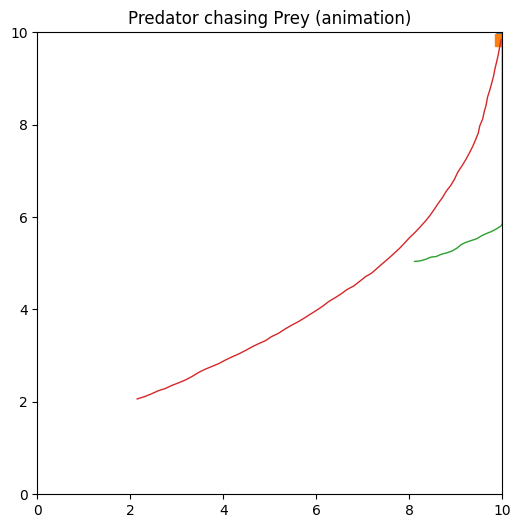

In [4]:
# Corrected animation cell
import matplotlib.animation as animation
from IPython.display import HTML
fig2, ax2 = plt.subplots(figsize=(6,6))
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_title('Predator chasing Prey (animation)')

# marker points (single-point markers need sequence-like args)
prey_dot, = ax2.plot([], [], marker='o', markersize=8, linestyle='')
pred_dot, = ax2.plot([], [], marker='s', markersize=8, linestyle='')

# trails (full sequences)
trail_prey, = ax2.plot([], [], linewidth=1)
trail_pred, = ax2.plot([], [], linewidth=1)

def init():
    prey_dot.set_data([], [])
    pred_dot.set_data([], [])
    trail_prey.set_data([], [])
    trail_pred.set_data([], [])
    return prey_dot, pred_dot, trail_prey, trail_pred

def update(i):
    # safety clamp to avoid indexing errors if frames > len(traj)
    i = min(i, len(prey_traj)-1)

    # single-point markers must be sequence-like (e.g. [x], [y])
    prey_x, prey_y = prey_traj[i,0], prey_traj[i,1]
    pred_x, pred_y = pred_traj[i,0], pred_traj[i,1]
    prey_dot.set_data([prey_x], [prey_y])
    pred_dot.set_data([pred_x], [pred_y])

    # trails can be full slices (empty slice ok for first frames)
    trail_prey.set_data(prey_traj[:i+1,0], prey_traj[:i+1,1])
    trail_pred.set_data(pred_traj[:i+1,0], pred_traj[:i+1,1])
    return prey_dot, pred_dot, trail_prey, trail_pred

frames = max(1, len(prey_traj))   # ensure at least 1 frame
anim = animation.FuncAnimation(fig2, update, init_func=init,
                               frames=frames, interval=40, blit=True)

# Show inline animation
HTML(anim.to_jshtml())


In [5]:
anim.save('predator_prey.mp4', fps=25, dpi=150)
from IPython.display import Video
Video('predator_prey.mp4', embed=True)


MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

Captured: True Capture step: 73


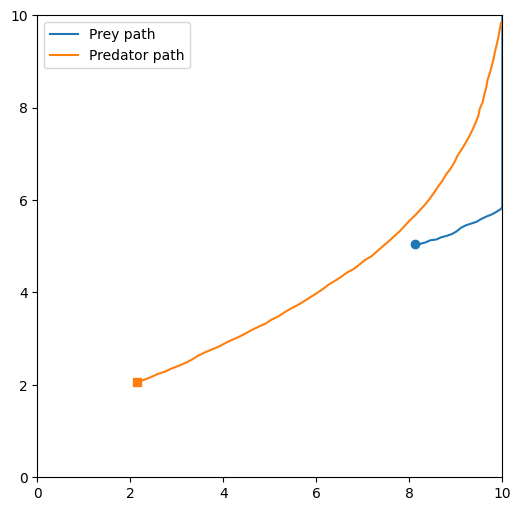

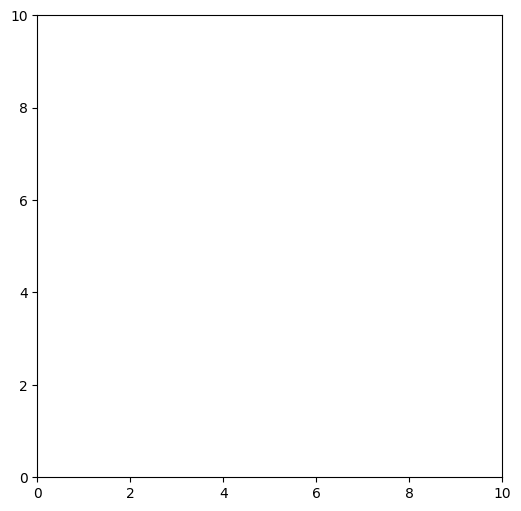

In [8]:
# Presentation-ready: runs sim, saves MP4, and shows video inline.
# Copy this full cell into your notebook and run it (it is self-contained).

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video, display
np.random.seed(1)

# World bounds
xlim, ylim = (0, 10), (0, 10)

class Agent:
    def __init__(self, pos, speed=1.0):
        self.pos = np.array(pos, dtype=float)
        self.speed = float(speed)
    def distance_to(self, other):
        return np.linalg.norm(self.pos - other.pos)

class Prey(Agent):
    def __init__(self, pos, speed=1.2, max_turn=np.pi/4):
        super().__init__(pos, speed)
        self.velocity = np.random.randn(2)
        self.velocity = self.velocity / np.linalg.norm(self.velocity) * self.speed
        self.max_turn = max_turn

    def step(self, predator, dt=0.1):
        away = self.pos - predator.pos
        if np.linalg.norm(away) < 1e-6:
            away = np.random.randn(2)
        away_dir = away / np.linalg.norm(away)
        jitter = np.random.randn(2) * 0.3
        desired = away_dir + 0.5 * jitter

        if np.linalg.norm(self.velocity) < 1e-8:
            self.velocity = np.array([1.0, 0.0])
        cur_dir = self.velocity / np.linalg.norm(self.velocity)
        des_dir = desired / np.linalg.norm(desired)
        ang = np.arctan2(des_dir[1], des_dir[0]) - np.arctan2(cur_dir[1], cur_dir[0])
        ang = (ang + np.pi) % (2*np.pi) - np.pi
        ang = np.clip(ang, -self.max_turn*dt*10, self.max_turn*dt*10)
        c, s = np.cos(ang), np.sin(ang)
        R = np.array([[c, -s], [s, c]])
        new_dir = R.dot(cur_dir)
        self.velocity = new_dir / np.linalg.norm(new_dir) * self.speed
        self.pos += self.velocity * dt
        # keep inside bounds
        self.pos[0] = np.clip(self.pos[0], xlim[0], xlim[1])
        self.pos[1] = np.clip(self.pos[1], ylim[0], ylim[1])

class Predator(Agent):
    def __init__(self, pos, speed=1.6):
        super().__init__(pos, speed)
        self.velocity = np.zeros(2)

    def interception_target(self, prey):
        p = self.pos
        q = prey.pos
        vq = getattr(prey, "velocity", np.zeros(2))
        rel = q - p
        rel_speed_sq = np.dot(vq, vq)
        if rel_speed_sq < 1e-6:
            return q
        dist = np.linalg.norm(rel)
        t_pred = dist / (self.speed + 1e-6)
        pred_point = q + vq * t_pred
        return pred_point

    def step(self, prey, dt=0.1):
        target = self.interception_target(prey)
        dir_to = target - self.pos
        if np.linalg.norm(dir_to) < 1e-8:
            dir_unit = np.zeros(2)
        else:
            dir_unit = dir_to / np.linalg.norm(dir_to)
        self.velocity = dir_unit * self.speed
        self.pos += self.velocity * dt
        self.pos[0] = np.clip(self.pos[0], xlim[0], xlim[1])
        self.pos[1] = np.clip(self.pos[1], ylim[0], ylim[1])

def run_simulation(dt=0.1, max_steps=800, capture_radius=0.3,
                   prey_start=(8.0,5.0), predator_start=(2.0,2.0),
                   prey_speed=1.2, predator_speed=1.6):
    prey = Prey(pos=prey_start, speed=prey_speed)
    predator = Predator(pos=predator_start, speed=predator_speed)
    prey_traj = []
    pred_traj = []
    captured = False
    capture_step = None
    for step in range(max_steps):
        prey.step(predator, dt=dt)
        predator.step(prey, dt=dt)
        prey_traj.append(prey.pos.copy())
        pred_traj.append(predator.pos.copy())
        if predator.distance_to(prey) <= capture_radius:
            captured = True
            capture_step = step
            break
    return np.array(prey_traj), np.array(pred_traj), captured, capture_step

# --- RUN the sim (you can change these params for demo) ---
prey_traj, pred_traj, captured, capture_step = run_simulation(
    prey_start=(8.0,5.0), predator_start=(2.0,2.0),
    prey_speed=1.2, predator_speed=1.6)

print("Captured:", captured, "Capture step:", capture_step)

# --- Plot & make animation ---
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.plot(prey_traj[:,0], prey_traj[:,1], label='Prey path')
ax.plot(pred_traj[:,0], pred_traj[:,1], label='Predator path')
ax.scatter(prey_traj[0,0], prey_traj[0,1], marker='o')
ax.scatter(pred_traj[0,0], pred_traj[0,1], marker='s')
ax.legend()
plt.show()
plt.close(fig)

# --- Animation (blit=False is more robust for inline display) ---
fig2, ax2 = plt.subplots(figsize=(6,6))
ax2.set_xlim(xlim); ax2.set_ylim(ylim)
prey_dot, = ax2.plot([], [], marker='o', markersize=8, linestyle='')
pred_dot, = ax2.plot([], [], marker='s', markersize=8, linestyle='')
trail_prey, = ax2.plot([], [], linewidth=1)
trail_pred, = ax2.plot([], [], linewidth=1)

def init():
    prey_dot.set_data([], []); pred_dot.set_data([], [])
    trail_prey.set_data([], []); trail_pred.set_data([], [])
    return prey_dot, pred_dot, trail_prey, trail_pred

def update(i):
    i = min(i, len(prey_traj)-1)
    prey_dot.set_data([prey_traj[i,0]], [prey_traj[i,1]])
    pred_dot.set_data([pred_traj[i,0]], [pred_traj[i,1]])
    trail_prey.set_data(prey_traj[:i+1,0], prey_traj[:i+1,1])
    trail_pred.set_data(pred_traj[:i+1,0], pred_traj[:i+1,1])
    return prey_dot, pred_dot, trail_prey, trail_pred

frames = max(1, len(prey_traj))
anim = animation.FuncAnimation(fig2, update, init_func=init,
                               frames=frames, interval=40, blit=False)

from IPython.display import HTML
HTML(anim.to_jshtml())   # ⭐ Shows animation directly inside notebook


### Notes & Next steps

- The predator uses a simple predictive heuristic (predict prey position after an estimated time and head there).
- The prey uses evasive steering, with bounded turning rate and random jitter to avoid purely deterministic motion.

Next improvements you might try:
- Implement a proper analytic interception solution (solving quadratic equation for intercept time).
- Add obstacles and path planning for the predator (A* / RRT).
- Replace predator with an RL agent (DQN / PPO) trained to minimize capture time.
- Add multiple predators or multiple prey and measure group tactics.
